In [2]:
import json
import os
import math
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
import structlog
import librosa
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io.wavfile import write

In [3]:
DATASET_PATH = "Tamil_dataset"
JSON_PATH = "pyt\hon_files1/data1.json"
json_path1 = "python_files1/data_2_new_2.json"
SAMPLE_RATE = 16000
TRACK_DURATION = 1 
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
DATA_PATH = "python_files1/data1.json"

In [4]:
def predict_1(model, X):
    
    X = X[np.newaxis, ...]

    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)
    if predicted_index == 0:
        print(" Your are affecting Dysarthria ")
    if predicted_index == 1:
        print(" Your are voice is Normal Level ")
    if predicted_index == 2:
        print(" Your are voice Not_audiable")
    if predicted_index == 3:
        print(" Your are affectings stuttering ")

    

In [5]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:
            
            semantic_label = dirpath.split("\\")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:
 
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                if len(signal) >= SAMPLE_RATE:
                    signals = signal
                else:
                    signal = np.pad(
                        signal,
                        pad_width=(SAMPLE_RATE - len(signal), 0),
                        mode="constant",
                        constant_values=(0, 0),
                    )

                for d in range(num_segments):

                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T                   
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [6]:
def load_data(data_path):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [7]:
def plot_history(history):

    fig, axs = plt.subplots(1)
    axs.plot(history.history["accuracy"], label="train accuracy")
    axs.plot(history.history["val_accuracy"], label="test accuracy")
    axs.set_ylabel("Accuracy")
    axs.legend(loc="lower right")
    axs.set_title("Accuracy eval")
    plt.show()
    fig, axs = plt.subplots(1)
    axs.plot(history.history["loss"], label="train error")
    axs.plot(history.history["val_loss"], label="test error")
    axs.set_ylabel("Error")
    axs.set_xlabel("Epoch")
    axs.legend(loc="upper right")
    axs.set_title("Error eval")
    plt.show()

In [8]:
def prepare_datasets(test_size, validation_size):


    X, y = load_data(DATA_PATH)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [9]:
def build_model(input_shape):

    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 
    
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(26, activation='softmax'))

    return model

In [10]:
def predict(model, X, y):
    
    X = X[np.newaxis, ...]

    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [11]:
if __name__ == "__main__":
    
    
    #save_mfcc(DATASET_PATH, JSON_PATH, num_segments=1)
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-11-3747e9cc121f>, line 6)

In [12]:
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.30, 0.20)

In [13]:
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

In [14]:
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
103/103 [==============================] - ETA: 0s - loss: 4.8825 - accuracy: 0.0000e+ - ETA: 3s - loss: 4.5312 - accuracy: 0.0156   - ETA: 3s - loss: 4.2664 - accuracy: 0.00 - ETA: 4s - loss: 4.2302 - accuracy: 0.00 - ETA: 4s - loss: 4.0864 - accuracy: 0.00 - ETA: 3s - loss: 3.9550 - accuracy: 0.01 - ETA: 4s - loss: 3.8549 - accuracy: 0.02 - ETA: 4s - loss: 3.8319 - accuracy: 0.02 - ETA: 4s - loss: 3.7667 - accuracy: 0.02 - ETA: 4s - loss: 3.7029 - accuracy: 0.03 - ETA: 4s - loss: 3.5817 - accuracy: 0.05 - ETA: 4s - loss: 3.5109 - accuracy: 0.06 - ETA: 3s - loss: 3.4197 - accuracy: 0.07 - ETA: 3s - loss: 3.3246 - accuracy: 0.08 - ETA: 3s - loss: 3.2816 - accuracy: 0.09 - ETA: 3s - loss: 3.1732 - accuracy: 0.11 - ETA: 3s - loss: 3.0914 - accuracy: 0.12 - ETA: 3s - loss: 3.0547 - accuracy: 0.13 - ETA: 3s - loss: 2.9648 - accuracy: 0.15 - ETA: 3s - loss: 2.8865 - accuracy: 0.18 - ETA: 3s - loss: 2.8436 - accuracy: 0.19 - ETA: 3s - loss: 2.7768 - accuracy: 0.21 - ETA: 3s - loss

103/103 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.84 - ETA: 3s - loss: 0.3873 - accuracy: 0.84 - ETA: 3s - loss: 0.3869 - accuracy: 0.85 - ETA: 4s - loss: 0.4339 - accuracy: 0.82 - ETA: 4s - loss: 0.4307 - accuracy: 0.82 - ETA: 4s - loss: 0.4279 - accuracy: 0.82 - ETA: 4s - loss: 0.4182 - accuracy: 0.82 - ETA: 4s - loss: 0.4015 - accuracy: 0.83 - ETA: 4s - loss: 0.4214 - accuracy: 0.82 - ETA: 4s - loss: 0.4231 - accuracy: 0.82 - ETA: 4s - loss: 0.4170 - accuracy: 0.83 - ETA: 4s - loss: 0.4250 - accuracy: 0.83 - ETA: 4s - loss: 0.4163 - accuracy: 0.83 - ETA: 4s - loss: 0.4158 - accuracy: 0.83 - ETA: 4s - loss: 0.4110 - accuracy: 0.84 - ETA: 3s - loss: 0.4086 - accuracy: 0.84 - ETA: 3s - loss: 0.4095 - accuracy: 0.84 - ETA: 3s - loss: 0.4042 - accuracy: 0.84 - ETA: 3s - loss: 0.3958 - accuracy: 0.84 - ETA: 3s - loss: 0.3955 - accuracy: 0.84 - ETA: 3s - loss: 0.3902 - accuracy: 0.85 - ETA: 3s - loss: 0.3885 - accuracy: 0.85 - ETA: 3s - loss: 0.3919 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.87 - ETA: 2s - loss: 0.2304 - accuracy: 0.92 - ETA: 3s - loss: 0.2578 - accuracy: 0.89 - ETA: 3s - loss: 0.2410 - accuracy: 0.90 - ETA: 4s - loss: 0.2412 - accuracy: 0.90 - ETA: 4s - loss: 0.2151 - accuracy: 0.91 - ETA: 4s - loss: 0.2408 - accuracy: 0.90 - ETA: 4s - loss: 0.2709 - accuracy: 0.89 - ETA: 3s - loss: 0.2597 - accuracy: 0.90 - ETA: 4s - loss: 0.2685 - accuracy: 0.90 - ETA: 3s - loss: 0.2618 - accuracy: 0.90 - ETA: 3s - loss: 0.2581 - accuracy: 0.90 - ETA: 3s - loss: 0.2512 - accuracy: 0.90 - ETA: 3s - loss: 0.2476 - accuracy: 0.90 - ETA: 3s - loss: 0.2460 - accuracy: 0.90 - ETA: 3s - loss: 0.2459 - accuracy: 0.90 - ETA: 3s - loss: 0.2388 - accuracy: 0.91 - ETA: 3s - loss: 0.2389 - accuracy: 0.91 - ETA: 3s - loss: 0.2353 - accuracy: 0.91 - ETA: 3s - loss: 0.2353 - accuracy: 0.91 - ETA: 3s - loss: 0.2322 - accuracy: 0.91 - ETA: 3s - loss: 0.2268 - accuracy: 0.91 - ETA: 3s - loss: 0.2296 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.90 - ETA: 3s - loss: 0.1825 - accuracy: 0.93 - ETA: 3s - loss: 0.1990 - accuracy: 0.93 - ETA: 4s - loss: 0.1966 - accuracy: 0.92 - ETA: 4s - loss: 0.1823 - accuracy: 0.92 - ETA: 4s - loss: 0.1764 - accuracy: 0.92 - ETA: 4s - loss: 0.1702 - accuracy: 0.93 - ETA: 4s - loss: 0.1688 - accuracy: 0.93 - ETA: 4s - loss: 0.1810 - accuracy: 0.93 - ETA: 4s - loss: 0.1754 - accuracy: 0.93 - ETA: 4s - loss: 0.1681 - accuracy: 0.93 - ETA: 4s - loss: 0.1672 - accuracy: 0.94 - ETA: 4s - loss: 0.1669 - accuracy: 0.94 - ETA: 4s - loss: 0.1726 - accuracy: 0.93 - ETA: 4s - loss: 0.1675 - accuracy: 0.94 - ETA: 4s - loss: 0.1639 - accuracy: 0.94 - ETA: 4s - loss: 0.1629 - accuracy: 0.94 - ETA: 4s - loss: 0.1678 - accuracy: 0.93 - ETA: 4s - loss: 0.1660 - accuracy: 0.93 - ETA: 4s - loss: 0.1655 - accuracy: 0.93 - ETA: 4s - loss: 0.1676 - accuracy: 0.93 - ETA: 4s - loss: 0.1685 - accuracy: 0.94 - ETA: 4s - loss: 0.1678 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.96 - ETA: 2s - loss: 0.1739 - accuracy: 0.94 - ETA: 3s - loss: 0.1780 - accuracy: 0.93 - ETA: 3s - loss: 0.1496 - accuracy: 0.94 - ETA: 3s - loss: 0.1421 - accuracy: 0.95 - ETA: 3s - loss: 0.1396 - accuracy: 0.95 - ETA: 3s - loss: 0.1376 - accuracy: 0.95 - ETA: 3s - loss: 0.1373 - accuracy: 0.95 - ETA: 3s - loss: 0.1395 - accuracy: 0.94 - ETA: 3s - loss: 0.1338 - accuracy: 0.95 - ETA: 3s - loss: 0.1342 - accuracy: 0.95 - ETA: 3s - loss: 0.1355 - accuracy: 0.95 - ETA: 3s - loss: 0.1339 - accuracy: 0.95 - ETA: 3s - loss: 0.1305 - accuracy: 0.95 - ETA: 3s - loss: 0.1287 - accuracy: 0.95 - ETA: 3s - loss: 0.1298 - accuracy: 0.95 - ETA: 3s - loss: 0.1279 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1239 - accuracy: 0.95 - ETA: 3s - loss: 0.1327 - accuracy: 0.95 - ETA: 3s - loss: 0.1447 - accuracy: 0.95 - ETA: 3s - loss: 0.1457 - accuracy: 0.95 - ETA: 2s - loss: 0.1435 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 2s - loss: 0.0849 - accuracy: 0.97 - ETA: 3s - loss: 0.0832 - accuracy: 0.97 - ETA: 3s - loss: 0.0915 - accuracy: 0.97 - ETA: 3s - loss: 0.0851 - accuracy: 0.97 - ETA: 3s - loss: 0.1009 - accuracy: 0.97 - ETA: 3s - loss: 0.1238 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1256 - accuracy: 0.95 - ETA: 3s - loss: 0.1233 - accuracy: 0.95 - ETA: 3s - loss: 0.1275 - accuracy: 0.95 - ETA: 3s - loss: 0.1235 - accuracy: 0.95 - ETA: 3s - loss: 0.1213 - accuracy: 0.95 - ETA: 3s - loss: 0.1195 - accuracy: 0.95 - ETA: 3s - loss: 0.1234 - accuracy: 0.95 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1201 - accuracy: 0.95 - ETA: 3s - loss: 0.1216 - accuracy: 0.95 - ETA: 3s - loss: 0.1215 - accuracy: 0.95 - ETA: 3s - loss: 0.1254 - accuracy: 0.95 - ETA: 3s - loss: 0.1241 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy: 0.95 - ETA: 3s - loss: 0.1291 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.93 - ETA: 2s - loss: 0.1364 - accuracy: 0.95 - ETA: 3s - loss: 0.1551 - accuracy: 0.95 - ETA: 3s - loss: 0.1408 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 3s - loss: 0.1313 - accuracy: 0.95 - ETA: 3s - loss: 0.1271 - accuracy: 0.95 - ETA: 3s - loss: 0.1237 - accuracy: 0.96 - ETA: 3s - loss: 0.1212 - accuracy: 0.95 - ETA: 3s - loss: 0.1373 - accuracy: 0.95 - ETA: 3s - loss: 0.1374 - accuracy: 0.94 - ETA: 3s - loss: 0.1324 - accuracy: 0.95 - ETA: 3s - loss: 0.1325 - accuracy: 0.95 - ETA: 3s - loss: 0.1294 - accuracy: 0.95 - ETA: 3s - loss: 0.1296 - accuracy: 0.95 - ETA: 3s - loss: 0.1264 - accuracy: 0.95 - ETA: 3s - loss: 0.1360 - accuracy: 0.95 - ETA: 3s - loss: 0.1334 - accuracy: 0.95 - ETA: 3s - loss: 0.1317 - accuracy: 0.95 - ETA: 3s - loss: 0.1282 - accuracy: 0.95 - ETA: 3s - loss: 0.1272 - accuracy: 0.95 - ETA: 3s - loss: 0.1260 - accuracy: 0.95 - ETA: 3s - loss: 0.1259 - accuracy

Epoch 16/30
103/103 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 1.00 - ETA: 2s - loss: 0.1028 - accuracy: 0.97 - ETA: 3s - loss: 0.1237 - accuracy: 0.96 - ETA: 3s - loss: 0.1175 - accuracy: 0.96 - ETA: 3s - loss: 0.1021 - accuracy: 0.96 - ETA: 3s - loss: 0.1189 - accuracy: 0.96 - ETA: 4s - loss: 0.1224 - accuracy: 0.95 - ETA: 3s - loss: 0.1244 - accuracy: 0.96 - ETA: 3s - loss: 0.1126 - accuracy: 0.96 - ETA: 3s - loss: 0.1064 - accuracy: 0.96 - ETA: 3s - loss: 0.1120 - accuracy: 0.96 - ETA: 3s - loss: 0.1103 - accuracy: 0.96 - ETA: 3s - loss: 0.1077 - accuracy: 0.96 - ETA: 3s - loss: 0.1170 - accuracy: 0.96 - ETA: 3s - loss: 0.1145 - accuracy: 0.96 - ETA: 3s - loss: 0.1136 - accuracy: 0.96 - ETA: 3s - loss: 0.1143 - accuracy: 0.96 - ETA: 3s - loss: 0.1183 - accuracy: 0.95 - ETA: 3s - loss: 0.1158 - accuracy: 0.96 - ETA: 3s - loss: 0.1134 - accuracy: 0.96 - ETA: 3s - loss: 0.1167 - accuracy: 0.96 - ETA: 3s - loss: 0.1197 - accuracy: 0.96 - ETA: 3s - loss: 0.119

103/103 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.96 - ETA: 2s - loss: 0.0446 - accuracy: 0.98 - ETA: 3s - loss: 0.1288 - accuracy: 0.93 - ETA: 3s - loss: 0.1262 - accuracy: 0.94 - ETA: 3s - loss: 0.1042 - accuracy: 0.95 - ETA: 3s - loss: 0.1021 - accuracy: 0.95 - ETA: 3s - loss: 0.1022 - accuracy: 0.95 - ETA: 3s - loss: 0.1039 - accuracy: 0.95 - ETA: 3s - loss: 0.1032 - accuracy: 0.95 - ETA: 4s - loss: 0.1048 - accuracy: 0.95 - ETA: 3s - loss: 0.1031 - accuracy: 0.95 - ETA: 3s - loss: 0.1017 - accuracy: 0.96 - ETA: 3s - loss: 0.0996 - accuracy: 0.96 - ETA: 3s - loss: 0.0979 - accuracy: 0.96 - ETA: 3s - loss: 0.0980 - accuracy: 0.96 - ETA: 3s - loss: 0.1026 - accuracy: 0.96 - ETA: 3s - loss: 0.1047 - accuracy: 0.95 - ETA: 3s - loss: 0.1022 - accuracy: 0.95 - ETA: 3s - loss: 0.1028 - accuracy: 0.95 - ETA: 3s - loss: 0.1046 - accuracy: 0.95 - ETA: 3s - loss: 0.1044 - accuracy: 0.95 - ETA: 2s - loss: 0.1012 - accuracy: 0.95 - ETA: 2s - loss: 0.0980 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 2s - loss: 0.0783 - accuracy: 0.96 - ETA: 3s - loss: 0.0742 - accuracy: 0.97 - ETA: 3s - loss: 0.0807 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.97 - ETA: 3s - loss: 0.0781 - accuracy: 0.97 - ETA: 3s - loss: 0.0731 - accuracy: 0.97 - ETA: 3s - loss: 0.0696 - accuracy: 0.97 - ETA: 3s - loss: 0.0692 - accuracy: 0.97 - ETA: 3s - loss: 0.0760 - accuracy: 0.96 - ETA: 3s - loss: 0.0766 - accuracy: 0.96 - ETA: 3s - loss: 0.0764 - accuracy: 0.96 - ETA: 3s - loss: 0.0842 - accuracy: 0.96 - ETA: 3s - loss: 0.0833 - accuracy: 0.96 - ETA: 2s - loss: 0.0861 - accuracy: 0.96 - ETA: 2s - loss: 0.0847 - accuracy: 0.96 - ETA: 2s - loss: 0.0812 - accuracy: 0.96 - ETA: 2s - loss: 0.0788 - accuracy: 0.96 - ETA: 2s - loss: 0.0789 - accuracy: 0.96 - ETA: 2s - loss: 0.0812 - accuracy: 0.96 - ETA: 2s - loss: 0.0797 - accuracy: 0.96 - ETA: 2s - loss: 0.0792 - accuracy: 0.96 - ETA: 2s - loss: 0.0821 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 1.00 - ETA: 2s - loss: 0.0944 - accuracy: 0.97 - ETA: 2s - loss: 0.0925 - accuracy: 0.98 - ETA: 3s - loss: 0.0789 - accuracy: 0.98 - ETA: 3s - loss: 0.0696 - accuracy: 0.98 - ETA: 3s - loss: 0.0724 - accuracy: 0.98 - ETA: 3s - loss: 0.0665 - accuracy: 0.98 - ETA: 3s - loss: 0.0600 - accuracy: 0.98 - ETA: 3s - loss: 0.0574 - accuracy: 0.98 - ETA: 3s - loss: 0.0565 - accuracy: 0.98 - ETA: 3s - loss: 0.0567 - accuracy: 0.98 - ETA: 3s - loss: 0.0672 - accuracy: 0.98 - ETA: 3s - loss: 0.0671 - accuracy: 0.98 - ETA: 2s - loss: 0.0673 - accuracy: 0.98 - ETA: 2s - loss: 0.0660 - accuracy: 0.98 - ETA: 2s - loss: 0.0651 - accuracy: 0.98 - ETA: 2s - loss: 0.0640 - accuracy: 0.98 - ETA: 2s - loss: 0.0671 - accuracy: 0.98 - ETA: 2s - loss: 0.0664 - accuracy: 0.98 - ETA: 2s - loss: 0.0660 - accuracy: 0.98 - ETA: 2s - loss: 0.0646 - accuracy: 0.98 - ETA: 2s - loss: 0.0737 - accuracy: 0.97 - ETA: 2s - loss: 0.0755 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.96 - ETA: 2s - loss: 0.0759 - accuracy: 0.96 - ETA: 2s - loss: 0.0608 - accuracy: 0.98 - ETA: 2s - loss: 0.0623 - accuracy: 0.97 - ETA: 3s - loss: 0.0713 - accuracy: 0.97 - ETA: 3s - loss: 0.0800 - accuracy: 0.96 - ETA: 3s - loss: 0.0777 - accuracy: 0.96 - ETA: 3s - loss: 0.0809 - accuracy: 0.96 - ETA: 3s - loss: 0.0774 - accuracy: 0.96 - ETA: 3s - loss: 0.0748 - accuracy: 0.96 - ETA: 3s - loss: 0.0742 - accuracy: 0.96 - ETA: 3s - loss: 0.0730 - accuracy: 0.96 - ETA: 3s - loss: 0.0742 - accuracy: 0.96 - ETA: 3s - loss: 0.0732 - accuracy: 0.96 - ETA: 3s - loss: 0.0702 - accuracy: 0.96 - ETA: 3s - loss: 0.0701 - accuracy: 0.96 - ETA: 3s - loss: 0.0700 - accuracy: 0.96 - ETA: 3s - loss: 0.0692 - accuracy: 0.96 - ETA: 3s - loss: 0.0693 - accuracy: 0.96 - ETA: 2s - loss: 0.0693 - accuracy: 0.96 - ETA: 2s - loss: 0.0700 - accuracy: 0.96 - ETA: 2s - loss: 0.0694 - accuracy: 0.96 - ETA: 2s - loss: 0.0699 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 2s - loss: 0.0861 - accuracy: 0.95 - ETA: 2s - loss: 0.0768 - accuracy: 0.96 - ETA: 3s - loss: 0.0862 - accuracy: 0.96 - ETA: 3s - loss: 0.0733 - accuracy: 0.96 - ETA: 3s - loss: 0.0802 - accuracy: 0.96 - ETA: 3s - loss: 0.0763 - accuracy: 0.96 - ETA: 3s - loss: 0.0894 - accuracy: 0.96 - ETA: 3s - loss: 0.0868 - accuracy: 0.96 - ETA: 3s - loss: 0.0841 - accuracy: 0.96 - ETA: 3s - loss: 0.0803 - accuracy: 0.97 - ETA: 3s - loss: 0.0805 - accuracy: 0.96 - ETA: 3s - loss: 0.0892 - accuracy: 0.96 - ETA: 3s - loss: 0.0830 - accuracy: 0.96 - ETA: 3s - loss: 0.0807 - accuracy: 0.96 - ETA: 2s - loss: 0.0779 - accuracy: 0.96 - ETA: 2s - loss: 0.0757 - accuracy: 0.96 - ETA: 2s - loss: 0.0752 - accuracy: 0.96 - ETA: 2s - loss: 0.0738 - accuracy: 0.96 - ETA: 2s - loss: 0.0729 - accuracy: 0.96 - ETA: 2s - loss: 0.0746 - accuracy: 0.97 - ETA: 2s - loss: 0.0735 - accuracy: 0.97 - ETA: 2s - loss: 0.0757 - accuracy

103/103 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 1.00 - ETA: 2s - loss: 0.0548 - accuracy: 1.00 - ETA: 2s - loss: 0.0539 - accuracy: 0.99 - ETA: 3s - loss: 0.0493 - accuracy: 0.99 - ETA: 3s - loss: 0.0520 - accuracy: 0.99 - ETA: 3s - loss: 0.0478 - accuracy: 0.99 - ETA: 3s - loss: 0.0605 - accuracy: 0.98 - ETA: 3s - loss: 0.0563 - accuracy: 0.98 - ETA: 3s - loss: 0.0558 - accuracy: 0.98 - ETA: 3s - loss: 0.0612 - accuracy: 0.98 - ETA: 3s - loss: 0.0642 - accuracy: 0.97 - ETA: 3s - loss: 0.0604 - accuracy: 0.98 - ETA: 3s - loss: 0.0590 - accuracy: 0.98 - ETA: 3s - loss: 0.0605 - accuracy: 0.97 - ETA: 3s - loss: 0.0584 - accuracy: 0.97 - ETA: 3s - loss: 0.0607 - accuracy: 0.97 - ETA: 3s - loss: 0.0599 - accuracy: 0.97 - ETA: 2s - loss: 0.0585 - accuracy: 0.97 - ETA: 2s - loss: 0.0587 - accuracy: 0.97 - ETA: 2s - loss: 0.0602 - accuracy: 0.97 - ETA: 2s - loss: 0.0609 - accuracy: 0.97 - ETA: 2s - loss: 0.0623 - accuracy: 0.97 - ETA: 2s - loss: 0.0618 - accuracy

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from keras.utils import to_categorical

Y_test = to_categorical(y_test, num_classes=3)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_pred,y_test)
print("confusion Matrix:")
print(cm)
cma =  precision_recall_fscore_support(y_pred,y_test)
print("\nprecision_recall:")
print(cma)

cma =  accuracy_score(y_pred,y_test)
print("\naccuracy_score:")
print(cma)
c=(y_test==1)
print(c)

confusion Matrix:
[[590   0   0]
 [  1 541  48]
 [  0  30 550]]

precision_recall:
(array([0.99830795, 0.9474606 , 0.91973244]), array([1.        , 0.91694915, 0.94827586]), array([0.99915326, 0.93195521, 0.93378608]), array([590, 590, 580], dtype=int64))

accuracy_score:
0.9551136363636363


AttributeError: 'numpy.ndarray' object has no attribute 'count'

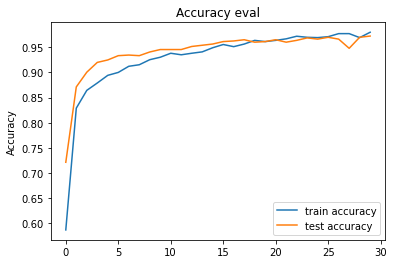

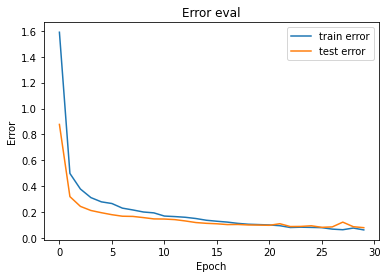

In [25]:
    plot_history(history)   

In [16]:
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

55/55 - 0s - loss: 0.1422 - accuracy: 0.9438

Test accuracy: 0.9437500238418579


In [17]:
    X_to_predict = X_test[30]
    y_to_predict = y_test[30]

    predict(model, X_to_predict, y_to_predict)

Target: 0, Predicted label: [0]


In [18]:
def test_data_analyze(file_path):
    data = {
        "mfcc": []
    }
    num_mfcc=13
    n_fft=2048
    hop_length=512
    num_segments=1
    c = 0
    k = 0
    
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    signal, sample_rate = librosa.load(file_path,sr=SAMPLE_RATE)
    if len(signal) >= SAMPLE_RATE:
        signals = signal
    else:
        signal = np.pad(
            signal,
            pad_width=(SAMPLE_RATE - len(signal), 0),
            mode="constant",
            constant_values=(0, 0),
        )
    start = samples_per_segment 
    finish = start + samples_per_segment
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T

    if len(mfcc) == num_mfcc_vectors_per_segment:
        data["mfcc"].append(mfcc.tolist())
    with open(json_path1, "w") as fp:
        json.dump(data, fp, indent=4)
    with open(json_path1, "r") as fp:
        data = json.load(fp)
    X = np.array(data["mfcc"])
    X = X[..., np.newaxis]
    y = X[0]
    y = y[np.newaxis, ...]

    prediction = model.predict(y)

    predicted_index = np.argmax(prediction, axis=1)
    #print(file_path)
    #print(predicted_index)
    return predicted_index

    

In [19]:
def vvvv():
    l=0
    h=0
    dataset_path='test'
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)): 
        for f in filenames: 
            file_path = os.path.join(dirpath, f)
            z=test_data_analyze(file_path)
            print(" target={} predicted_index= {} number={} ".format((h-1), z,h))
            if z == h-1:
                #print(" target={} predicted_index= {} number={} ".format((h-1), z,h))
                l = l + 1
        h += 1
        print(" ************target={}  ".format(l))
    print("Test_data_accurasy={}".format(l/3))


In [20]:
vvvv()

 ************target=0  
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [2] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [2] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [0] number=1 
 target=0 predicted_index= [2] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [1] number=1 
 target=0 predicted_index= [1] nu